# FFT with Python

In this file you will find FFT implementations.

After completing the FPGA implementation, I've noticed that the chosen algorithm doesn't detect the frequency when it falls between two frequencies calculated by the FFT. For example, if the step size is 1 Hz, the signal at x.5 Hz won't be visible. This is a major drawback of this implementation.

## Import dependencies

In [456]:
import numpy as np
import matplotlib.pyplot as plt
import math

## Create a signal

In [457]:
# Signal parameters
fe = 256  # Sampling frequency (Hz)
N = fe   # The number of points required is the frequency (fe) to have a 1Hz step.
t = np.arange(N) / fe  # Time vector
f1 = 32  # Hz
f2 = 64  # Hz

# Generated the signal
signal = np.sin(2 * np.pi * f1 * t) + 0.5 * np.sin(2 * np.pi * f2 * t)
samples:np.ndarray = np.zeros((N,2))
samples[:, 0] = signal

# Additional parameters
n_positive = N // 2
frequencies = np.fft.fftfreq(N, d=1/fe)
frequencies_positive = frequencies[:n_positive]

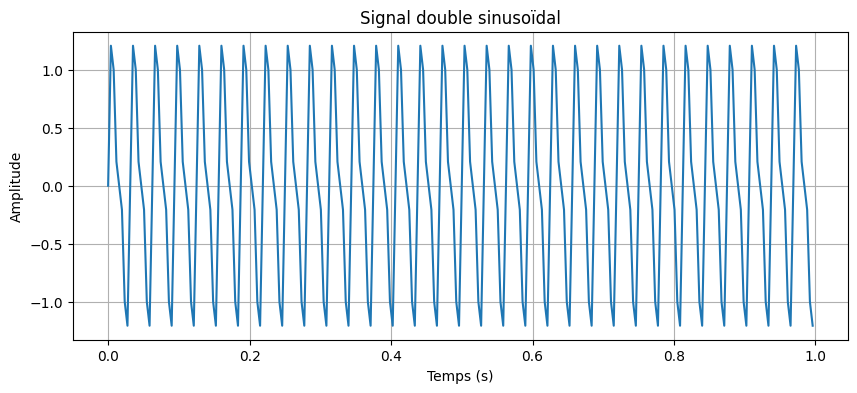

In [458]:
# Show signal after sampling
plt.figure(figsize=(10, 4))
plt.plot(t, signal)
plt.title("Signal double sinusoïdal")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

## Numpy implementation of FFT

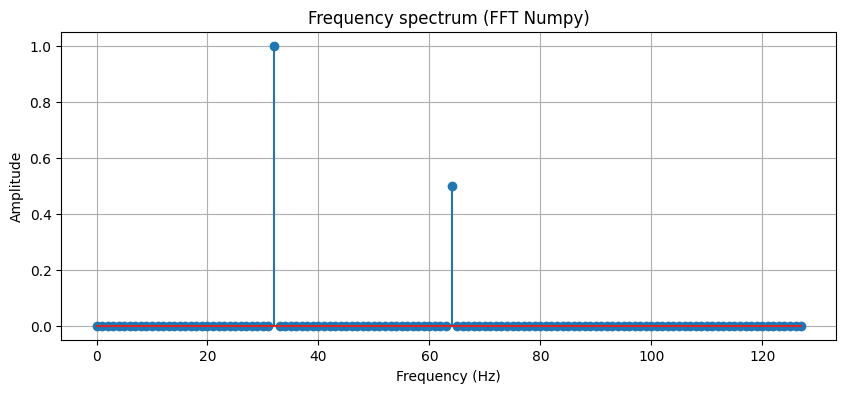

In [459]:
# Compute FFT
fft_result = np.fft.fft(signal)

# Post processing
fft_magnitude = 2.0 / N * np.abs(fft_result[:n_positive])

# Displaying the frequency spectrum
plt.figure(figsize=(10, 4))
plt.stem(frequencies_positive, fft_magnitude)
plt.title("Frequency spectrum (FFT Numpy)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

## Custom software FFT implementation

In [460]:
# Complexe operations for addition, subtraction and multiplication
def complexAdd(base, sup):
    return [base[0]+sup[0],base[1]+sup[1]]
def complexSub(base, sup):
    return [base[0]-sup[0],base[1]-sup[1]]
def complexMul(base, sup):
    return [base[0]*sup[0]-base[1]*sup[1],base[1]*sup[0]+base[0]*sup[1]]

# Recursive algorithme find on Youtube and write in Python
def recursiveFFT(samples: np.ndarray) -> np.ndarray:
    N = samples.shape[0]
    if (N <= 1):
        return samples
    M = int(N/2)
    even = samples[::2, :]
    odd = samples[1::2, :]
    even = recursiveFFT(even)
    odd = recursiveFFT(odd)
    output = np.zeros((N,2))
    twiddleFactor = np.zeros((1,2))
    for k in range(M):
        twiddleFactor = [np.cos(2*np.pi*(k/N)),-np.sin(2*np.pi*(k/N))]
        twiddleOdd = complexMul(twiddleFactor, odd[k])
        output[k] = complexAdd(even[k], twiddleOdd)
        output[k+M] = complexSub(even[k], twiddleOdd)
    return output

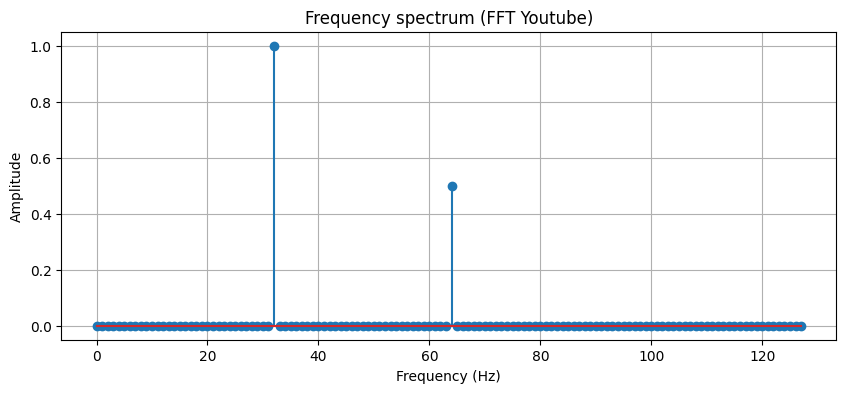

In [461]:
# Compute FFT
res = recursiveFFT(samples)

# Post processing
fft_magnitude = (2.0 / N) * np.abs(res[:n_positive])

# Displaying the frequency spectrum
plt.figure(figsize=(10, 4))
plt.stem(frequencies_positive, fft_magnitude[:,1])
plt.title("Frequency spectrum (FFT Youtube)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

Values compute at each stage.

| index | Stage 0           | Stage 1           | Stage 2               | Stage 3               |
| ---   | ---               | ---               | ---                   | ---                   |
| 0     | [0.00 , 0.00]     | [3.06e-16 , 0.00] | [3.06e-16 , 0.00]     | [-3.59e-16 , 0.00]    |
| 1     | [1.06 , 0.00]     | [-4.44e-16 , 0.00]| [-6.66e-16 , 0.00]    | [9.72e-16 , 0.00]     |
| 2     | [0.50 , 0.00]     | [0.00 , 0.00]     | [3.06e-16 , 0.00]     | [-2.28e-17 , -4.00]   |
| 3     | [1.06 , 0.00]     | [-2.22e-16 , 0.00]| [-2.22e-16 , 0.00]    | [-4.66e-16 , 2.00]    |
| 4     | [3.06e-16 , 0.00] | [-3.06e-16 , 0.00]| [-2.44e-16 , -1.00]   | [3.06e-16 , 2.22e-16] |
| 5     | [-1.06 , 0.00]    | [2.12 , 0.00]     | [2.12 , -2.12]        | [3.06e-16 , -2.22e-16]|
| 6     | [-0.05 , 0.00]    | [1.00 , 0.00]     | [-3.67e-16 , 1.00]    | [-1.45e-16 , -2.00]   |
| 7     | [-1.06 , 0.00]    | [2.12 , 0.00]     | [2.12 , 2.12]         | [-5.89e-16 , 4.00]    |

## FPGA implementation of FFT

But I want an implementation closer to the one in the FPGA, so I write an other implementation.

In [ ]:
# Calculate the indices after successive even/odd division
def orderedIndex(samples: np.ndarray) -> np.ndarray:
    N = samples.shape[0]
    if (N <= 1):
        return samples
    M = int(N/2)
    even = samples[::2]
    odd = samples[1::2]
    even = orderedIndex(even)
    odd = orderedIndex(odd)
    output = np.zeros(N)
    for k in range(M):
        output[k] = even[k]
        output[k+M] = odd[k]
    return output

# Calculate the value of the twiddle factor
def twiddleFactorComputation():
    global twiddleFactorComputed
    global indexOrdered
    power = int(math.log2(N))
    for i in range(power):
        M = 2**i
        Q = M*2
        for k in range(M):
            twiddleFactorComputed[M+k] = [np.cos(2*np.pi*(k/Q)),-np.sin(2*np.pi*(k/Q))]
        sorted_index = np.argsort(indexOrdered[:M])
        twiddleFactorComputed[M:2*M, :] = twiddleFactorComputed[M:2*M, :][sorted_index]

# Calculate the value of k
def kCompute(k,M,n, Mmax):
    temp = n-M
    if temp >= 0:
        return [k,temp]
    else:
        return [k+1,Mmax-M]

# Calculate the FFT
def fpgaFFT():
    global memory
    global twiddleFactorComputed
    power = int(math.log2(N))
    Ndiv2 = N//2
    for i in range(power):
        M = 2**i
        pas = (Ndiv2)>>i
        counter = 0
        k = 0
        n=Ndiv2
        for p in range(Ndiv2):
            k,n = kCompute(k,M,n,Ndiv2)
            if counter%pas==0 and counter!=0 :
                counter = counter + pas
            addresse_1 = counter
            addresse_2 = addresse_1 + pas
            even = memory[addresse_1]
            odd = memory[addresse_2]
            twiddleOdd = complexMul(twiddleFactorComputed[M+k], odd)
            memory[addresse_2] = complexSub(even, twiddleOdd)
            memory[addresse_1] = complexAdd(even, twiddleOdd)
            counter = counter + 1

# Arrange the memory to have an order consistent with a normal FFT
def filterMemory():
    global memory
    memory_filtered = np.copy(memory)
    sorted_index = np.argsort(indexOrdered)
    for i in range(sorted_index.shape[0]):
        memory_filtered[i] = np.copy(memory[sorted_index[i]])
    return memory_filtered

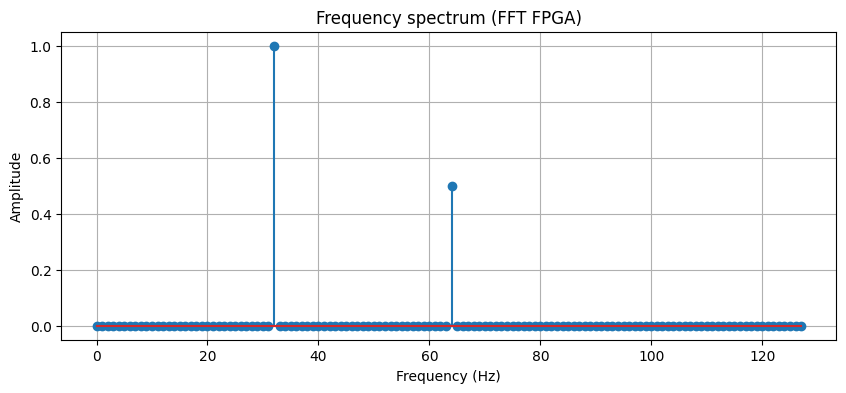

In [463]:
# Setup variables
memory: np.ndarray = np.copy(samples)
index:np.ndarray = np.zeros(N)
index[:] = np.arange(N)
twiddleFactorComputed:np.ndarray = np.zeros((N,2))

# Pre processing twiddle factors and index order
indexOrdered = orderedIndex(index)
twiddleFactorComputation()

# Processing the FFT
fpgaFFT()

# Post processing
memory_filtered = filterMemory()
fft_magnitude = (2.0 / N) * np.abs(memory_filtered[:n_positive])

# Displaying the frequency spectrum
plt.figure(figsize=(10, 4))
plt.stem(frequencies_positive, fft_magnitude[:,1])
plt.title("Frequency spectrum (FFT FPGA)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()